In [49]:

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [52]:
!conda list

# packages in environment at /home/team1/anaconda3/envs/tmp:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
_tflow_select             2.1.0                       gpu    anaconda
absl-py                   0.15.0             pyhd3eb1b0_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py39h7f8727e_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
astunparse                1.6.3                      py_0    anaconda
attrs                     21.4.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                    openblas    anaconda
bleach                    4.1.0              pyhd3eb1b0_0  
blinker                   1.4              py39h06a4308_0  
brotli                    1.0.9                he6710b0_2  


In [1]:
import os
import zipfile

In [2]:
os.listdir('./base_act')

['test_set', 'train_set', 'base.zip']

In [3]:
# 기본 경로
base_dir = './base_act'
train_dir = base_dir + '/train_set'
test_dir = base_dir + '/test_set'

In [4]:
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
from tensorflow.keras import layers

2022-03-22 04:39:16.815716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [20]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                 rotation_range = 40,
                                                                 width_shift_range=0.2,
                                                                 height_shift_range=0.2,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.2
                                                                 )

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_data = train_generator.flow_from_directory(train_dir,batch_size=32, target_size=(224, 224))
# train_data = image_generator.flow_from_directory(train_dir,batch_size=32, target_size=(224, 224))
test_data = image_generator.flow_from_directory(test_dir,batch_size=32, target_size=(224, 224))

Found 5979 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [21]:
for train_batch, label_batch in train_data:
  print("Image batch shape: ", train_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)


In [22]:
for test_batch, label_batch in test_data:
  print("Image batch shape: ", test_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)


In [23]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5"

In [9]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

2022-03-22 04:39:37.881690: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-22 04:39:37.882841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-22 04:39:37.924537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 04:39:37.926334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-03-22 04:39:37.926360: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-22 04:39:37.928243: I tensorflow/stream_executor/platform/defau

In [24]:
feature_batch = feature_extractor_layer(train_batch)
print(feature_batch.shape)

(32, 1024)


In [25]:
feature_extractor_layer.trainable = False

In [26]:
with tf.device("/gpu:0"):
    model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(train_data.num_classes, activation='softmax')
    ])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1024)              3228864   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 3,235,014
Trainable params: 6,150
Non-trainable params: 3,228,864
_________________________________________________________________


In [28]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [29]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-03-22 05:45:14.896826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 05:45:14.897174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-03-22 05:45:14.897221: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-22 05:45:14.897246: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-22 05:45:14.897254: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-03-22 05:45:14.897261: I tensorflow/stream_executor/p

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1732679074475393526,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 31589217152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17731176526210805871
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:03:00.0, compute capability: 7.0"]

22-03-22 05:45:14.897849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-22 05:45:14.897853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2022-03-22 05:45:14.897857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2022-03-22 05:45:14.897924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 05:45:14.898180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 05:45:14.898418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/device:GPU:0 with 30125 MB memory) -> physical GPU (device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:03:00

In [30]:
import time, random, datetime
import numpy as np
import tensorflow as tf
class DataLoader(tf.keras.utils.Sequence):
    def __len__(self):
        return 10
    def __getitem__(self, i):
        time.sleep(random.randint(1,2))
        #you could add a print here to see that it's out of order
        return i

In [45]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()
batch_stats_callback = CollectBatchStats()

In [31]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size)
steps_test_per_epoch = np.ceil(test_data.samples/test_data.batch_size)


In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    steps_per_epoch=steps_per_epoch,
                    epochs=15,
                    validation_steps=steps_test_per_epoch,
                    verbose=2)


Epoch 1/15
187/187 - 843s - loss: 1.6489 - acc: 0.3353 - val_loss: 1.4739 - val_acc: 0.3500
Epoch 2/15
187/187 - 840s - loss: 1.2363 - acc: 0.5347 - val_loss: 1.3427 - val_acc: 0.4750
Epoch 3/15
187/187 - 841s - loss: 1.0623 - acc: 0.6167 - val_loss: 1.0858 - val_acc: 0.5750
Epoch 4/15
187/187 - 852s - loss: 0.9569 - acc: 0.6635 - val_loss: 1.0149 - val_acc: 0.6042
Epoch 5/15
187/187 - 844s - loss: 0.8612 - acc: 0.7103 - val_loss: 0.9234 - val_acc: 0.6167
Epoch 6/15
187/187 - 843s - loss: 0.7921 - acc: 0.7307 - val_loss: 0.9139 - val_acc: 0.6250
Epoch 7/15
187/187 - 839s - loss: 0.7576 - acc: 0.7454 - val_loss: 0.8973 - val_acc: 0.6375
Epoch 8/15
187/187 - 840s - loss: 0.7389 - acc: 0.7428 - val_loss: 0.8338 - val_acc: 0.6667
Epoch 9/15
187/187 - 844s - loss: 0.6922 - acc: 0.7719 - val_loss: 0.8101 - val_acc: 0.7000
Epoch 10/15


In [72]:
import time
t = time.time()

export_path = "MobileNet v1_100_224"
# model.save(export_path, save_format='tf')
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: MobileNet v1_100_224/assets


INFO:tensorflow:Assets written to: MobileNet v1_100_224/assets


'MobileNet v1_100_224'

In [96]:
reloaded = tf.keras.models.load_model('./black-belt/AImodel/base_two/' + export_path)

In [97]:
result_batch = model.predict(test_batch)
reloaded_result_batch = reloaded.predict(test_batch)

In [98]:
reloaded.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              1280      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7686      
Total params: 8,966
Trainable params: 7,686
Non-trainable params: 1,280
_________________________________________________________________


In [27]:
class_names = sorted(test_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Bodyhit_Left', 'Bodyhit_Right', 'Midblock_Left', 'Midblock_Right',
       'Topblock_Left', 'Topblock_Right'], dtype='<U14')

In [35]:
predicted_batch = model.predict(test_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [36]:
label_id = np.argmax(label_batch, axis=-1)

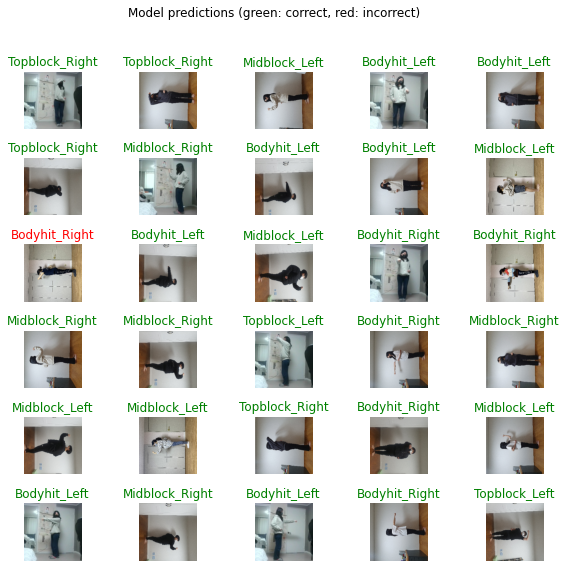

In [37]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(test_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")